# Basic Comms Modulation Recognition Neural Network Example

In [1]:
import os, random, sys
import warnings; warnings.simplefilter("ignore")
import numpy as np 
import pandas as pd 
import pickle
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.models as models
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers import Convolution2D, ZeroPadding2D
import keras.models as models
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import confusion_matrix

2025-03-30 20:08:37.458111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 20:08:37.466089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743365317.475541   11479 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743365317.478524   11479 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743365317.485892   11479 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Load and Pre-Process Data

In [2]:
xd =  pickle.load(open('/code/data/RML2016.10a_dict.dat','rb'),encoding='latin1')

In [3]:
snrs,mods = [sorted(list(set([x[j] for x in list(xd.keys())]))) for j in [1,0]]
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(xd[(mod,snr)])
        for i in range(xd[(mod,snr)].shape[0]):  
            lbl.append((mod,snr))
X = np.vstack(X)

In [4]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


## Sequential Model Architecture

In [5]:
dr = 0.2
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, activation = 'relu'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(200, 1, 3, activation = 'relu'))  
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(150, 1, 3, activation = 'relu'))  
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, activation = 'relu'))  
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, activation = 'relu'))  
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(len(classes)))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mse','mae','mape'])
model.summary()

I0000 00:00:1743365319.889190   11479 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21320 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 1, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1, 2, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 1, 6, 256)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 2, 200)      │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 2, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 1, 6, 200)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 2, 150)      │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 2, 150)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 1, 6, 150)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 2, 80)       │        12,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 2, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_4                │ (None, 1, 6, 80)       │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 2, 80)       │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 2, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,177 (692.10 KB)

 Trainable params: 177,177 (692.10 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
## Training

In [7]:
nb_epoch = 100
batch_size = 1024

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=True,
    class_weight=None,
    )

# saving the model to save later
model.save('/code/model/model_weights.h5')

Epoch 1/100


I0000 00:00:1743365321.575901   11611 service.cc:152] XLA service 0x31a3ee80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743365321.575928   11611 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-30 20:08:41.602838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743365321.780537   11611 cuda_dnn.cc:529] Loaded cuDNN version 90300


 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1168 - loss: 2.3566 - mae: 0.1637 - mape: 81829064.0000 - mse: 0.0818

I0000 00:00:1743365323.913577   11611 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.1199 - loss: 2.3454 - mae: 0.1632 - mape: 81602168.0000 - mse: 0.0816 - val_accuracy: 0.1625 - val_loss: 2.2015 - val_mae: 0.1570 - val_mape: 78495456.0000 - val_mse: 0.0788
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1742 - loss: 2.1552 - mae: 0.1562 - mape: 78076736.0000 - mse: 0.0781 - val_accuracy: 0.2503 - val_loss: 1.9690 - val_mae: 0.1503 - val_mape: 75140888.0000 - val_mse: 0.0746
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2468 - loss: 1.9865 - mae: 0.1503 - mape: 75147648.0000 - mse: 0.0752 - val_accuracy: 0.2919 - val_loss: 1.8727 - val_mae: 0.1449 - val_mape: 72426992.0000 - val_mse: 0.0715
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2875 - loss: 1.8976 - mae: 0.1448 - mape: 72381256.0000 - mse: 0.0723 - val_accuracy: 0.3206 - val_loss: 1.8051 - val_mae: 0.1404 - val_mape: 70183912.0000 - val_mse: 0.0694
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

In [8]:
# loading the model from checkpoint if desired to start here
model = load_model('/code/model/model_weights.h5')

# testing the model
score = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3847 - loss: 1.8059 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 66464296.0000 - mean_squared_error: 0.0678


## Plotting Accuracy and Loss

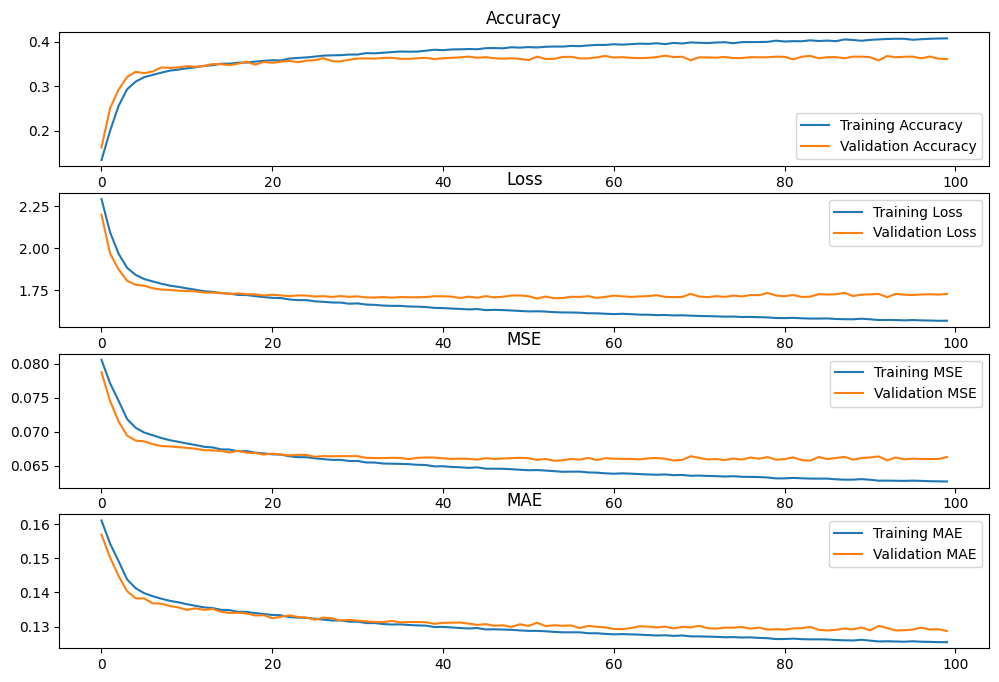

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(4, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Loss')

plt.subplot(4, 1, 3)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend(loc = 'upper right')
plt.title('MSE')

plt.subplot(4, 1, 4)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc = 'upper right')
plt.title('MAE')
plt.savefig("/code/images/accuracy_and_loss.png")
plt.show()

## Calculate & Plot Confusion Matrix

3438/3438 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step
Normalized confusion matrix


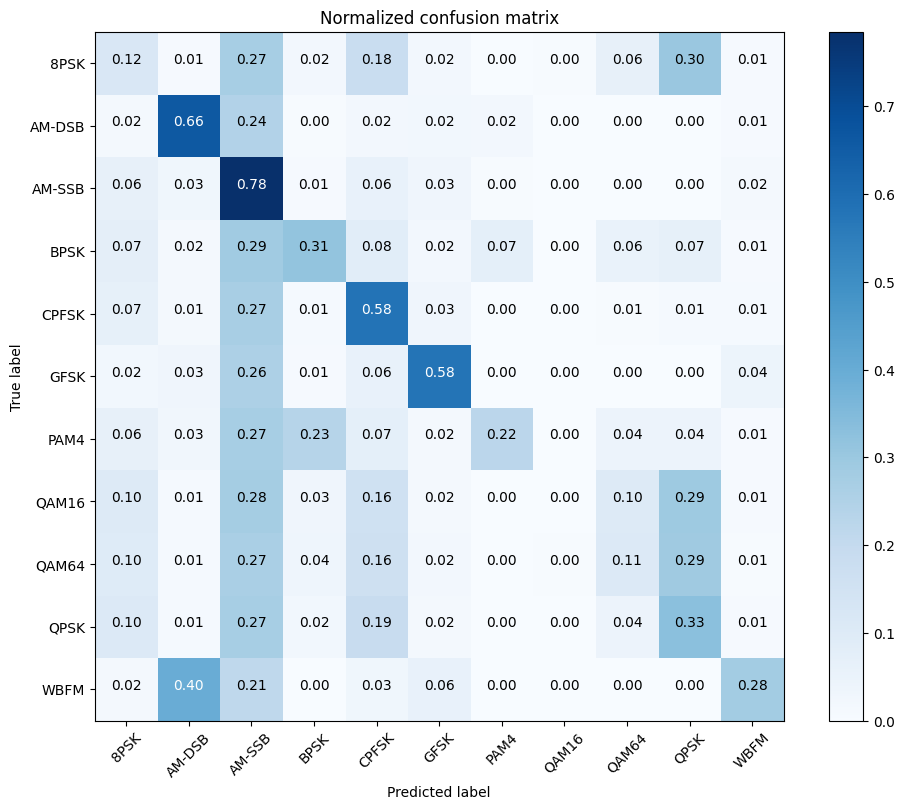

In [12]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
cnf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=mods, normalize=True,
                        title='Normalized confusion matrix')
plt.savefig("/code/images/confusion_matrix.png")
plt.show()